# Email Automatically Labeling

### Data Set:
The Enron email dataset contains 517401 emails generated by 150 employees of the Enron Corporation, mostly senior management of Enron, organized into folders. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. This dataset does not include attachments. Invalid email addresses were converted to something of the form user@enron.com whenever possible (i.e., recipient is specified in some parse-able format like "Doe, John" or "Mary K. Smith") and to no_address@enron.com when no recipient was specified.

https://www.cs.cmu.edu/~./enron/ May 7, 2015 Version 

In [4]:
#import os, sys, email, re
import email, re
import numpy as np 
import pandas as pd
from pandas.core.common import flatten

# Plotting
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import wordcloud

# Network analysis
#import networkx as nx

# NLP
#from nltk.tokenize.regexp import RegexpTokenizer

#from subprocess import check_output

#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA
#from sklearn.lda import LDA
#from sklearn.decomposition import LatentDirichletAllocation

#import gensim
#from gensim import corpora
#from nltk.corpus import stopwords 
#from nltk.stem.wordnet import WordNetLemmatizer
#import string
#from nltk.stem.porter import PorterStemmer

# 1. Loading and cleaning data

In [5]:
# Read the data into a DataFrame
df_emails = pd.read_csv('../Data/emails.csv')

In [6]:
print("There are total {} emails.".format(df_emails.shape[0]))

There are total 517401 emails.


In [7]:
#Show the first 10 emails in the data frame.
df_emails.head(10)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
5,allen-p/_sent_mail/1002.,Message-ID: <30965995.1075863688265.JavaMail.e...
6,allen-p/_sent_mail/1003.,Message-ID: <16254169.1075863688286.JavaMail.e...
7,allen-p/_sent_mail/1004.,Message-ID: <17189699.1075863688308.JavaMail.e...
8,allen-p/_sent_mail/101.,Message-ID: <20641191.1075855687472.JavaMail.e...
9,allen-p/_sent_mail/102.,Message-ID: <30795301.1075855687494.JavaMail.e...


In [8]:
#Show the message of a sample email with multi-part bodys. 
print(df_emails['message'][10471])

Message-ID: <27086631.1075854806617.JavaMail.evans@thyme>
Date: Tue, 24 Oct 2000 02:57:00 -0700 (PDT)
From: eric.bass@enron.com
To: shanna.husser@enron.com
Subject: Re: It could happen!!!
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Eric Bass
X-To: Shanna Husser
X-cc: 
X-bcc: 
X-Folder: \Eric_Bass_Jun2001\Notes Folders\'sent mail
X-Origin: Bass-E
X-FileName: ebass.nsf

Thought you might like Superfan's comments.
---------------------- Forwarded by Eric Bass/HOU/ECT on 10/24/2000 09:56 AM 
---------------------------
   
	Enron North America Corp.
	
	From:  Eric Bass                           10/24/2000 09:53 AM
	

To: Chad Landry/HOU/ECT@ECT
cc: Matthew Lenhart/HOU/ECT@ECT, Christopher Coffman/Corp/Enron@Enron, 
William Kelly/HOU/ECT@ECT, Kyle Etter/HOU/ECT@ECT, Kam Keiser/HOU/ECT@ECT, 
Jay Reitmeyer/HOU/ECT@ECT, Jeff Coates/HOU/ECT@ECT, William 
Keeney/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT, John King/HOU/ECT@ECT, 
Luis Mena/

In [9]:
#Show the message of a sample email with Cc and Bcc. 
#print(df_emails['message'][10000])

In [10]:
#We can see that the headers include Message-ID, Date, From, To, Cc, Bcc, Subject, Mime-Version, 
#Content-Type, Content-Transfer-Encoding, X-From, X-To, X-cc, X-bcc, X-Folder, X-Origin
#X-FileName, and message body. We are only interested in the headers: X-Origin(i.e.,Employee Name), Date, From, To, Cc, Bcc, 
#Subject, message body, and X-Folder.

In [11]:
## Helper functions
def get_message_body(msg):
    '''To get the message body from email headers'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            text = ''.join(part.get_payload().split('-----Original Message-----'))
            parts.append(re.sub('\n|\t', ' ', text).strip()  )        
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = list(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

def drop_none(line):
    '''To drop None from email list'''
    return sorted(list([a for a in line if a]))

In [12]:
headers = list(map(email.message_from_string, df_emails['message']))

In [13]:
bodies = list(map(get_message_body, headers))

In [14]:
#bodies[10471]

In [15]:
#headers[10000].items()

In [16]:
headers_sel = ["X-Origin", "Date", "From", "To", "Cc", "Bcc", "Subject", "X-Folder"]

In [17]:
for key in headers_sel:
    df_emails[key] = [message[key] for message in headers]

In [18]:
df_emails.columns

Index(['file', 'message', 'X-Origin', 'Date', 'From', 'To', 'Cc', 'Bcc',
       'Subject', 'X-Folder'],
      dtype='object')

In [19]:
email_folder = df_emails['file'].apply(lambda x: x.split('/'))
Employee,Folder,Email_Number=[],[],[]
for i in email_folder.index:
    Employee.append(email_folder[i][0])
    #Folder.append(email_folder[i][1])
    Folder.append('/'.join(email_folder[i][1:-1]))
    Email_Number.append(email_folder[i][-1])
df_emails['Employee'], df_emails['Folder'], df_emails['Email Number'] = Employee, Folder, Email_Number

In [20]:
#print(df_emails["Body"][9])

In [21]:
# Parse content from emails
df_emails['Body'] = list(map(get_message_body, headers))
# Split multiple email addresses
df_emails['From'] = df_emails['From'].map(split_email_addresses)
df_emails['To'] = df_emails['To'].map(split_email_addresses)
df_emails['Cc'] = df_emails['Cc'].map(split_email_addresses)
df_emails['Bcc'] = df_emails['Bcc'].map(split_email_addresses)

In [22]:
df_emails.head()

,file,message,X-Origin,Date,From,To,Cc,Bcc,Subject,X-Folder,Employee,Folder,Email Number,Body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Allen-P,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",[phillip.allen@enron.com],[tim.belden@enron.com],None,None,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Allen-P,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",[phillip.allen@enron.com],[john.lavorato@enron.com],None,None,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Allen-P,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",[phillip.allen@enron.com],[leah.arsdall@enron.com],None,None,Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,Allen-P,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",[phillip.allen@enron.com],[randall.gay@enron.com],None,None,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Allen-P,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",[phillip.allen@enron.com],[greg.piper@enron.com],None,None,Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.


In [23]:
df_emails["Related Party"] =[set(flatten([df_emails["From"][a],df_emails["To"][a],df_emails["Cc"][a],df_emails["Bcc"][a]])) for a in range(len(df_emails["To"])) ]

In [24]:
df_emails["Related Party"] = df_emails["Related Party"].map(drop_none)

In [25]:
df_emails.head()

,file,message,X-Origin,Date,From,To,Cc,Bcc,Subject,X-Folder,Employee,Folder,Email Number,Body,Related Party
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Allen-P,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",[phillip.allen@enron.com],[tim.belden@enron.com],None,None,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast,"[phillip.allen@enron.com, tim.belden@enron.com]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Allen-P,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",[phillip.allen@enron.com],[john.lavorato@enron.com],None,None,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...,"[john.lavorato@enron.com, phillip.allen@enron...."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Allen-P,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",[phillip.allen@enron.com],[leah.arsdall@enron.com],None,None,Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!,"[leah.arsdall@enron.com, phillip.allen@enron.com]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,Allen-P,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",[phillip.allen@enron.com],[randall.gay@enron.com],None,None,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal...","[phillip.allen@enron.com, randall.gay@enron.com]"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Allen-P,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",[phillip.allen@enron.com],[greg.piper@enron.com],None,None,Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.,"[greg.piper@enron.com, phillip.allen@enron.com]"


In [26]:
#print(df_emails["Related Party"][10000])

In [27]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 15 columns):
file             517401 non-null object
message          517401 non-null object
X-Origin         517372 non-null object
Date             517401 non-null object
From             517401 non-null object
To               495554 non-null object
Cc               127881 non-null object
Bcc              127881 non-null object
Subject          517401 non-null object
X-Folder         517372 non-null object
Employee         517401 non-null object
Folder           517401 non-null object
Email Number     517401 non-null object
Body             517401 non-null object
Related Party    517401 non-null object
dtypes: object(15)
memory usage: 59.2+ MB


In [28]:
#Check missing values
print('Check missing values:\n', df_emails.isnull().sum())

Check missing values:
 file                  0
message               0
X-Origin             29
Date                  0
From                  0
To                21847
Cc               389520
Bcc              389520
Subject               0
X-Folder             29
Employee              0
Folder                0
Email Number          0
Body                  0
Related Party         0
dtype: int64


In [29]:
#print(df_emails.iloc[18178])

In [30]:
print(df_emails.iloc[18178].Body)

Wednesday,  September  19th   3 - 3:30pm Room - 3125b Mime-Version: 1.0 Content-Type: text/plain; charset=us-ascii Content-Transfer-Encoding: 7bit X-From: Baughman Jr., Don </O=ENRON/OU=NA/CN=RECIPIENTS/CN=DBAUGHM> X-To:  X-cc:  X-bcc:  X-Folder: \ExMerge - Baughman Jr., Don\Calendar X-Origin: BAUGHMAN-D X-FileName: don baughman 6-25-02.PST  Midwest/Southeast Desk Meeting w/Fletch Sturm Wednesday,  September 19th   3 - 3:30pm Room - 3125b


In [31]:
#print(df_emails.iloc[18178].message)

In [32]:
#headers[18178].items()

In [33]:
#email.message_from_string(df_emails['message'][18178]).items()

In [34]:
#print(df_emails['message'][43636])

In [35]:
#print(df_emails.iloc[43636])

In [36]:
#df_emails[df_emails["To"].isnull()]

In [37]:
#print(df_emails.iloc[188])

In [38]:
#print(df_emails['message'][188])

In [39]:
#print(df_emails['message'][603])

In [40]:
#print(df_emails['message'][1236])

In [41]:
df_emails.drop(['To', 'Cc','Bcc', 'X-Origin'], axis=1, inplace=True)

In [42]:
#df_emails.isna().sum()

In [43]:
df_emails.dropna(axis=0, inplace=True)

In [44]:
df_emails.isna().sum()

file             0
message          0
Date             0
From             0
Subject          0
X-Folder         0
Employee         0
Folder           0
Email Number     0
Body             0
Related Party    0
dtype: int64

In [45]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517372 entries, 0 to 517400
Data columns (total 11 columns):
file             517372 non-null object
message          517372 non-null object
Date             517372 non-null object
From             517372 non-null object
Subject          517372 non-null object
X-Folder         517372 non-null object
Employee         517372 non-null object
Folder           517372 non-null object
Email Number     517372 non-null object
Body             517372 non-null object
Related Party    517372 non-null object
dtypes: object(11)
memory usage: 47.4+ MB


In [46]:
df_emails.head()

,file,message,Date,From,Subject,X-Folder,Employee,Folder,Email Number,Body,Related Party
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",[phillip.allen@enron.com],,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast,"[phillip.allen@enron.com, tim.belden@enron.com]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",[phillip.allen@enron.com],Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...,"[john.lavorato@enron.com, phillip.allen@enron...."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",[phillip.allen@enron.com],Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!,"[leah.arsdall@enron.com, phillip.allen@enron.com]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",[phillip.allen@enron.com],,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal...","[phillip.allen@enron.com, randall.gay@enron.com]"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",[phillip.allen@enron.com],Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.,"[greg.piper@enron.com, phillip.allen@enron.com]"


# Exploratory Data Analysis

In [47]:
# Number of emails by Employee
df_emails.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kaminski-v       28463
dasovich-j       28234
kean-s           25351
mann-k           23381
jones-t          19950
shackleton-s     18687
taylor-m         13875
farmer-d         13032
germany-c        12436
beck-s           11830
symes-k          10827
nemec-g          10655
scott-s           8022
rogers-b          8009
bass-e            7823
sanders-r         7329
campbell-l        6489
shapiro-r         6071
guzman-m          6054
lay-k             5937
lenhart-m         5919
lokay-m           5568
kitchen-l         5545
haedicke-m        5245
sager-e           5199
love-p            5002
arnold-j          4898
fossum-d          4796
perlingiere-d     4778
lavorato-j        4685
mcconnell-m       4542
giron-d           4220
skilling-j        4139
shankman-j        3856
hain-m            3820
delainey-d        3566
williams-w3       3440
blair-l           3415
mclaughlin-e      3353
whalley-l         3335
Name: message, dtype: int64

In [48]:
# Number of emails by folder
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder            
dasovich-j     all_documents         11896
jones-t        all_documents          9304
shackleton-s   all_documents          8158
dasovich-j     notes_inbox            7194
kaminski-v     all_documents          7174
mann-k         all_documents          6647
kaminski-v     discussion_threads     5550
taylor-m       all_documents          5229
jones-t        notes_inbox            5095
mann-k         discussion_threads     4965
kean-s         calendar/untitled      4478
               archiving/untitled     4477
               all_documents          4477
mann-k         sent                   4440
nemec-g        all_documents          4231
mann-k         _sent_mail             4220
dasovich-j     sent                   3930
jones-t        sent                   3810
shackleton-s   sent                   3774
kean-s         discussion_threads     3733
farmer-d       all_documents          3660
kaminski-v     _sent_mail             3464
               sent 

In [49]:
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][61:120]

Employee      Folder             
stclair-c     all_documents          1523
shapiro-r     deleted_items          1468
nemec-g       inbox                  1466
dasovich-j    sent_items             1436
bass-e        _sent_mail             1409
fossum-d      all_documents          1405
williams-w3   schedule_crawler       1398
dasovich-j    inbox                  1387
bass-e        discussion_threads     1386
steffes-j     sent_items             1379
lay-k         inbox                  1373
bass-e        sent                   1363
lewis-a       deleted_items          1359
germany-c     sent_items             1353
hain-m        all_documents          1347
stclair-c     sent                   1328
symes-k       sent                   1326
lokay-m       all_documents          1324
symes-k       _sent_mail             1323
kean-s        sent                   1315
campbell-l    inbox                  1315
shapiro-r     all_documents          1270
skilling-j    inbox                  1252


In [50]:
print(df_emails['Body'][10471])

Thought you might like Superfan's comments. ---------------------- Forwarded by Eric Bass/HOU/ECT on 10/24/2000 09:56 AM  ---------------------------      Enron North America Corp.    From:  Eric Bass                           10/24/2000 09:53 AM    To: Chad Landry/HOU/ECT@ECT cc: Matthew Lenhart/HOU/ECT@ECT, Christopher Coffman/Corp/Enron@Enron,  William Kelly/HOU/ECT@ECT, Kyle Etter/HOU/ECT@ECT, Kam Keiser/HOU/ECT@ECT,  Jay Reitmeyer/HOU/ECT@ECT, Jeff Coates/HOU/ECT@ECT, William  Keeney/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT, John King/HOU/ECT@ECT,  Luis Mena/NA/Enron@Enron, shirley.s.elliott@citicorp.com @ ENRON, Lisa  Gillette/HOU/ECT@ECT, Susan M Scott/HOU/ECT@ECT, Dawn C Kenne/HOU/ECT@ECT,  Nick Hiemstra/HOU/ECT@ECT, Benjamin Thomason/HOU/ECT@ECT, David  Marks/HOU/ECT@ECT, Timothy Blanchard/HOU/EES@EES  Subject: Re: It could happen!!!    Easy there Superfan!  Remember, you still have to win 1 of your last 3 games,  none of those are gimmes (see UAB).  As far as bowls go,  LSU

In [51]:
#print(df_emails.loc[108711]['message'])

In [52]:
df_emails[df_emails['Employee']=='farmer-d'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                    3660
discussion_threads               3387
logistics                        1192
_sent_mail                        747
sent                              710
tufco                             609
deleted_items                     378
wellhead                          339
personal                          321
sent_items                        258
industrials                       236
pan_energy_swap                   164
cleburne_plant____cornhusker_     148
ces                               141
enron_news                        134
deleted_items/personal            104
entex                             102
inbox                              85
cornhusker                         67
unify                              37
resumes                            27
bankruptcy                         23
sitara                             20
contracts                          18
term_proposals                     18
calendar                           14
eol  

In [53]:
df_emails[df_emails['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                         7174
discussion_threads                    5550
_sent_mail                            3464
sent                                  3463
deleted_items                         1792
sent_items                            1696
inbox                                  560
resumes                                547
c/mangmt/group/management              526
c/technote/mail/projects               379
universities                           367
c/mangmt/ene_ect                       288
personal                               281
c/mangmt/group/software/management     276
conferences                            223
notes_inbox                            223
london                                 195
c/technote/mail/techmemos              187
rice                                   175
australia                              112
var                                    110
eci/eci                                108
ut                                      76
stan

In [54]:
df_emails_cleaned = df_emails.copy()

In [55]:
folder_del = ['all_documents','discussion_threads','_sent_mail','sent','sent_items','notes_inbox','deleted_items']

In [56]:
sum=0
for fd in folder_del:
    sum=+len(df_emails_cleaned[df_emails_cleaned['Folder']==fd])
    df_emails_cleaned.drop(df_emails_cleaned[df_emails_cleaned['Folder']==fd].index, axis=0, inplace=True)

In [57]:
sum

50987

In [58]:
# Number of emails by Employee
df_emails_cleaned.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kean-s          14590
kaminski-v       5101
kitchen-l        4211
farmer-d         3885
williams-w3      2921
beck-s           2890
taylor-m         2850
lokay-m          2610
dasovich-j       2214
shackleton-s     2132
shapiro-r        2063
mann-k           1968
symes-k          1861
germany-c        1852
blair-l          1785
campbell-l       1761
rogers-b         1734
lay-k            1696
watson-k         1557
nemec-g          1521
white-s          1481
salisbury-h      1479
baughman-d       1456
sanders-r        1375
jones-t          1362
skilling-j       1321
steffes-j        1297
stokley-c        1252
dean-c           1238
buy-r            1189
scott-s          1090
may-l            1088
saibi-e          1033
wolfe-j           993
whalley-g         939
sager-e           933
griffith-j        909
mclaughlin-e      902
hyvl-d            898
corman-s          892
Name: message, dtype: int64

In [59]:
# Number of emails by folder
df_emails_cleaned.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder                               
kean-s         calendar/untitled                        4478
               archiving/untitled                       4477
               attachments                              2026
nemec-g        inbox                                    1466
williams-w3    schedule_crawler                         1398
dasovich-j     inbox                                    1387
lay-k          inbox                                    1373
campbell-l     inbox                                    1315
skilling-j     inbox                                    1252
farmer-d       logistics                                1192
lokay-m        tw_commercial_group                      1159
salisbury-h    inbox                                    1152
buy-r          inbox                                    1143
blair-l        meetings                                 1120
may-l          inbox                                    1087
shackleton-s   inbox            

In [60]:
df_emails_cleaned[df_emails_cleaned['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
inbox                                 560
resumes                               547
c/mangmt/group/management             526
c/technote/mail/projects              379
universities                          367
c/mangmt/ene_ect                      288
personal                              281
c/mangmt/group/software/management    276
conferences                           223
london                                195
c/technote/mail/techmemos             187
rice                                  175
australia                             112
var                                   110
eci/eci                               108
ut                                     76
stanford                               76
credit                                 65
calendar                               60
evaluation                             57
risk                                   54
ei                                     51
consultants                            44
sites                      

In [61]:
df_emails_cleaned[df_emails_cleaned['Employee']=='kitchen-l'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
_americas/esvl                715
_americas/mrha/ooc            309
_americas/hr                  306
_americas/east_power          257
_americas/regulatory          242
_americas/portland            203
_americas/ooc                 202
_americas/eol                 171
_americas/it                  149
inbox                         140
_americas/asset_marketing     103
_americas/mexico               96
_americas/netco_eol            91
_americas/gas                  87
_americas/sec_media            84
_americas/turbines             83
_americas/mrha                 82
_americas/netco_hr             82
_americas/finance              68
_americas/press                61
_americas/netco_restart        61
_americas/business_plans       58
_americas/tammie               50
_americas/restructuring        49
_americas/netco_legal          48
calendar                       38
_americas/hpl                  37
_americas/board                34
_americas/sec                  30
_americ

In [62]:
df_emails_cleaned[df_emails_cleaned['Employee']=='kean-s'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:20]

Folder
calendar/untitled             4478
archiving/untitled            4477
attachments                   2026
california                     682
heat_wave                      244
ferc                           188
pr_crisis_management            92
federal_legislation             88
inbox                           85
rto                             78
india                           75
california___working_group      72
environmental_issues            71
europe                          61
japan                           61
presentations                   61
personal                        52
project_summer                  51
humor                           48
pge                             46
Name: message, dtype: int64

In [63]:
df_emails_cleaned[df_emails_cleaned['Employee']=='beck-s'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
inbox                     751
europe                    166
calendar                  126
recruiting                116
doorstep                   88
congratulations            83
eol_access                 67
eol                        57
mg                         55
wilson__shona              52
prc/2000_year_end          49
personal                   48
japan                      46
org_announc____chrts       42
prc                        41
commoditylogic             41
analyst_assoc_program      40
sap                        39
hpl                        34
egm                        30
resumes                    30
solmonson__mary            29
hr/mcloughlin__hector      28
var                        27
hall__bob                  24
causey__rick               23
dpr                        22
delainey__dave             21
unify                      21
commercialization          20
entelligence               20
offsite                    20
apollo__beth               19
gos

# Prepare simpletransformers input data

In [64]:
kaminski_v_email = df_emails_cleaned[df_emails_cleaned['Employee']=='kaminski-v']

In [65]:
kaminski_v_email.drop(kaminski_v_email[kaminski_v_email['Folder']=='inbox'].index, axis=0, inplace=True)

/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
kv_labels_count = kaminski_v_email.groupby('Folder').count().sort_values(by='file', ascending=False)['message']

In [67]:
min_num_email = 60
kv_labels_count['other'] = kv_labels_count[kv_labels_count<min_num_email].values.sum()

In [68]:
kv_labels = kv_labels_count[kv_labels_count>=min_num_email].keys()

In [69]:
kv_labels

Index(['resumes', 'c/mangmt/group/management', 'c/technote/mail/projects',
       'universities', 'c/mangmt/ene_ect', 'personal',
       'c/mangmt/group/software/management', 'conferences', 'london',
       'c/technote/mail/techmemos', 'rice', 'australia', 'var', 'eci/eci',
       'stanford', 'ut', 'credit', 'calendar', 'other'],
      dtype='object', name='Folder')

In [70]:
kv_labels_id = list(range(len(kv_labels)))
num_labels = len(kv_labels_id)

In [71]:
num_labels

19

In [72]:
kv_labels_id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [73]:
kv_labels_count[kv_labels]

Folder
resumes                               547
c/mangmt/group/management             526
c/technote/mail/projects              379
universities                          367
c/mangmt/ene_ect                      288
personal                              281
c/mangmt/group/software/management    276
conferences                           223
london                                195
c/technote/mail/techmemos             187
rice                                  175
australia                             112
var                                   110
eci/eci                               108
stanford                               76
ut                                     76
credit                                 65
calendar                               60
other                                 490
Name: message, dtype: int64

In [74]:
kaminski_v_email['labels'] = kv_labels_id[-1] # assign all labels to 'other'
for i in range(len(kv_labels_id)-1):
    kaminski_v_email.loc[kaminski_v_email['Folder']==kv_labels[i],'labels'] = i

/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [75]:
kaminski_v_email_input = pd.DataFrame(kaminski_v_email[['Body','labels']])

In [76]:
kaminski_v_email_input.columns = ['text','labels']

In [77]:
kaminski_v_email_input.groupby('labels').count()

,text
labels,
0,547
1,526
2,379
3,367
4,288
5,281
6,276
7,223
8,195


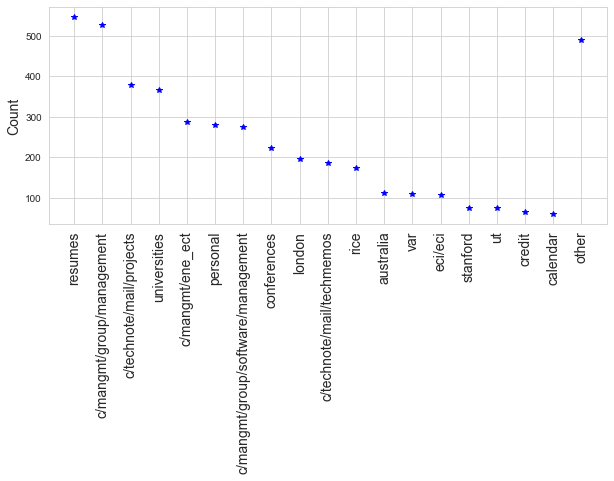

In [78]:
plt.figure(figsize=(10,4))
plt.plot(kv_labels, kaminski_v_email_input.groupby('labels').count(), 'b*')
plt.ylabel('Count', fontsize=14)
plt.xticks(
    rotation=90,
    fontsize=14,
)
plt.show()


In [79]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y=train_test_split(kaminski_v_email_input['text'],kaminski_v_email_input['labels'],test_size=0.3,random_state=0)

In [80]:
train_data = {'text':train_X.values, 'labels':train_y.values}

In [81]:
train_df = pd.DataFrame(data=train_data)

In [82]:
train_df

,text,labels
0,Thank you for your event RSVP. We hope that t...,7
1,"John, I hope you had a good Easter weekend. ...",8
2,"Howard, Thanks for the message and the paper....",3
3,New market we are trying to develop in Benzene...,8
4,"Hi Vince, I was not aware of the ""Power Play""...",4
...,...,...
3173,Your eRequest's password is 4311 To use this p...,6
3174,"Graham Pl. #207 Austin, TX 78705 (512) 4746683...",0
3175,"Mark, Thanks for the info. I shall check it o...",9
3176,Hi guys A number of us interviewed a guy name...,8


In [83]:
eval_data = {'text':test_X.values, 'labels':test_y.values}
eval_df = pd.DataFrame(eval_data)

In [84]:
eval_df 

,text,labels
0,--------- Inline attachment follows --------- ...,17
1,Dear Dr. Kaminski: Thank-you once again for in...,0
2,"Vince: Per Susan's email below, do you want t...",14
3,Mike: We are currently being billed for Frees...,4
4,"Ken A tour would be great (after 10:30, if th...",10
...,...,...
1358,"Molly, We would like to bring this student as...",1
1359,PRC is just around the corner and Dave has not...,18
1360,BUSINESS HIGHLIGHTS East Power Group Enron Po...,4
1361,"Dear Professor Kaminski, Thanks for spending ...",18


In [85]:
# Write to file
import pickle
f_myfile = open('myfileJan23.pickle', 'wb')
pickle.dump(kaminski_v_email, f_myfile)
f_myfile.close()
 


In [86]:
# Read from file
import pickle
f_myfile = open('myfileJan23.pickle', 'rb')
kaminski_v_email = pickle.load(f_myfile)  # variables come out in the order you put them in
f_myfile.close()

In [87]:
from simpletransformers.classification import ClassificationModel

In [88]:
# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=num_labels, args={'reprocess_input_data': True, 'overwrite_output_dir': True, 'sliding_window': True}, use_cuda=False) 
# You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

predictions, raw_outputs = model.predict(["Some arbitary sentence"])

Converting to features started. Cache is not used.
sliding_window enabled



15687 features created from 3178 samples.


Running loss: 1.449679

Training of bert model complete. Saved to outputs/.
Converting to features started. Cache is not used.
sliding_window enabled



1363 features created from 1363 samples.



Converting to features started. Cache is not used.
sliding_window enabled



1 features created from 1 samples.


In [91]:
result

{'mcc': 0.5528183770014452, 'eval_loss': 1.4594187842761994}

In [93]:
predictions

array([18])